## [Lecture 11.1: K-means clustering on digit dataset](https://www.youtube.com/watch?v=-tPSKI9nUf0)

In this notebook, we will implement `K-Means` algorithm with `sklearn`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# KMeans clustering
from sklearn.cluster import KMeans

# Loading the digit dataset
from sklearn.datasets import load_digits

# Selecting k through silhoutte score
from sklearn.metrics import silhouette_score

# Normalization through MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

### Clustering of digits
We will use digit dataset for clustering, which is loaded through `load_digit` API
- It loads 8x8 digit images which is approximately 180 samples per class
- From 10 classes, it has total of 1797 images
- Each pixel has value between 0 and 16

In [2]:
digits = load_digits()

Let's quickly check `KMeans` class as implemented in `sklearn.cluster` module

In [3]:
?KMeans

Some of the important parameters are as follows:
- `init`
- `n_init`
- `max_iter`
- `random_state`

Since KMeans algorithm is susceptible to local minima,we perform `KMeans` fit and select the ones with the lowest value of sum of squared error

The total number of time, we would like to run KMeans algorithm is specified through `n_init` parameter.

`max_iter` specifies total number of iterations before declaring convergence.

Let's define parameters of KMeans clustering algorithm in a dictionary object.

In [4]:
kmeans_kwargs = {
    'init': 'random',
    'n_init': 50,
    'max_iter': 500,
    'random_state': 0
}

Let's define a pipeline with two stages:
- Preprocessing for feature scaling with `MinMaxScaler`.
- Clustering with `KMeans` clustering algorithm

In [5]:
pipeline = Pipeline([('Preprocess', MinMaxScaler()),
                     ('Clustering', KMeans(n_clusters=10, **kmeans_kwargs))])
pipeline.fit(digits.data)

Pipeline(steps=[('Preprocess', MinMaxScaler()),
                ('Clustering',
                 KMeans(init='random', max_iter=500, n_clusters=10, n_init=50,
                        random_state=0))])

The cluster centroids can be accessed via `cluster_centers_` member variable of `KMeans` class.

In [6]:
cluster_centers = pipeline[-1].cluster_centers_

Let's display cluster centroids:

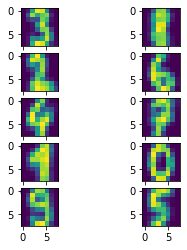

In [7]:
# displaying centroids
fig, ax = plt.subplots(5, 2, figsize=(4, 4))
for i, j in zip(ax.flat, cluster_centers.reshape(10, 8, 8)):
    i.imshow(j)

In this case, the number of clusters were known. Hence we set `k=10` and got the clusters

For deciding the optimal number of clusters through elbow and silhoutte, we will pretend that we do not know the number of clusters in the data and we will try to discover the optimal number through these two methods one by one:

### Elbow method
Here we keep track of sum-of-squared error (SSE) in a list for each value of k.

In [8]:
# Identifying the correct number of clusters
sse_digit = []
scaled_digits = MinMaxScaler().fit_transform(digits.data)
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_digits)
    sse_digit.append(kmeans.inertia_)

Note that SSE for a given clustering output is obtained through `inertia_` member variable.

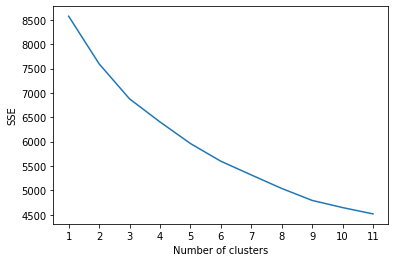

In [9]:
plt.plot(range(1, 12), sse_digit)
plt.xticks(range(1, 12))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

There is a slight elbow at `k=9` which could point to the fact that a few digits may have been merged in one cluster.

### Silhoutte

In [10]:
sil_coef_digits = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_digits)
    score = silhouette_score(digits.data, kmeans.labels_)
    sil_coef_digits.append(score) 

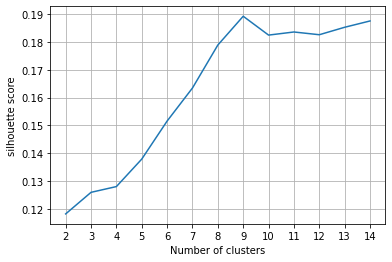

In [11]:
plt.plot(range(2, 15), sil_coef_digits)
plt.xticks(range(2, 15))
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.grid(True)
plt.show()

In [12]:
# get the value of K for which silhouette score is highest
print(np.argmax(sil_coef_digits)+2)

9


This graph points the fact that n=9 this could mean some digits like 1 and 7 make striking similarity

## [Lecture 11.2: Hierarchical Agglomerative Clustering (HAC)](https://www.youtube.com/watch?v=GG6yYMO91FQ)
Clustering is concerned about grouping objects with *similar attributes* or *characteristics*. The objects in the same cluster are closer to one and another than the objects from the other clusters

<img src="images/cluster.png"/>

In the image above, the clusters with the same color share similar properties (Feature values represented on axis). For instance, if the x-axis represents weight and y-axis represent height, then the red cluster represents people with low BMI. Similar interpretations can be drawn for the remaining clusters.

Here we will discuss another clustering algorithm which is **hierarchial aggglomerative clustering (HAC)** algorithm
- Hierarchial clustering starts by considering each datum as cluster and then combines closest clusters to form larger clusters. This is bottom-up approach
- There is an alternate approach, which is top-down approach, where the entire data is one large single cluster, which is divided into smaller clusters in each step.

The merging and splitting decisions are influenced by certain conditions that will discussed shortly.

### Metric
Certain metrics are used for calculating similarity between clusters. Note that metric is a generalization of concept of distance. The metrics follow certain properties like:
1. non-negative
2. symmetric
3. follows triangle inequality

Some of the popular metric function are:
1. **Euclidean**:
$$d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \sqrt{\sum_{l=1}^m (\mathbf{x}_l^{(i)} - \mathbf{x}_l^{(j)})^2}$$
2. **Manhattan**:
$$d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) =  \sum_{l=1}^m |(\mathbf{x}_l^{(i)} - \mathbf{x}_l^{(j)})|$$
3. **Cosine distance**:
$$d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = 1 - \frac{\mathbf{x}^{(i)}\mathbf{x}^{(j)}}{||\mathbf{x}^{(i)}|| \times ||\mathbf{x}^{(j)}||} = 1 - cos (\theta)$$

### Linkage
Linkage is a strategy for aggregating clusters

There are four linkages we will study
- Single linkage
- Average linkage
- Complete linkage
- Ward's linkage

The single linkage criterion merges clusters based on the shortest distance over all possible pairs . That is
$$(\{\mathbf{x}_{r_1}^{(i)}\}_{i=1}^{|r_1|}, \{\mathbf{x}_{r_2}^{(j)}\}_{j=1}^{|r_2|}) = \text{min}_{i,j} d(\mathbf{x}_{r_1}^{(i)}, \mathbf{x}_{r_2}^{(j)}) $$

<img src="images/SingleLinkage.png" />

The complete linkage merges clusters to minimize the maximum distance between the clusters (in other words, distance of the furthest elements).

$$(\{\mathbf{x}_{r_1}^{(i)}\}_{i=1}^{|r_1|}, \{\mathbf{x}_{r_2}^{(j)}\}_{j=1}^{|r_2|}) = \text{max}_{i,j} d(\mathbf{x}_{r_1}^{(i)}, \mathbf{x}_{r_2}^{(j)})$$

<img src="images/CompleteLinkage.png" />

The average linkage criterion uses average distance over all possible pairs between the groups for merging clusters

$$(\{\mathbf{x}_{r_1}^{(i)}\}_{i=1}^{|r_1|}, \{\mathbf{x}_{r_2}^{(j)}\}_{j=1}^{|r_2|}) = \frac{1}{|r_1||r_2|} \sum_{i=1}^{|r_1|}\sum_{j=1}^{|r_2|} d(\mathbf{x}_{r_1}^{(i)}, \mathbf{x}_{r_2}^{(j)}) $$

<img src="images/AverageLinkage.png" />

The ward's linkage computes the sum of squared distances within the clusters
$$(\{\mathbf{x}_{r_1}^{(i)}\}_{i=1}^{|r_1|}, \{\mathbf{x}_{r_2}^{(j)}\}_{j=1}^{|r_2|}) =  \sum_{i=1}^{|r_1|}\sum_{j=1}^{|r_2|} ||\mathbf{x}_{r_1}^{(i)} - \mathbf{x}_{r_2}^{(j)}||^2 $$


### Hierarchical Aggolomerative Clustering

Algorithm:
1. Calculate the distance matrix between pairs and clusters
2. While all the objects are clustered into one.
    - Detect the two closest groups (clusters) and merge them


### Dendrograms 
Dendrograms are graphical representation of the agglomerative process which show how an aggregation happens at each level. Let's take example of toy dataset to understand this.

Example:

| $x_1$ | $x_2$ |
| --- | --- |
| 8 | 3 |
| 5 | 3 |
| 6 | 4 |
| 1 | 6 |
| 2 | 8 |

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

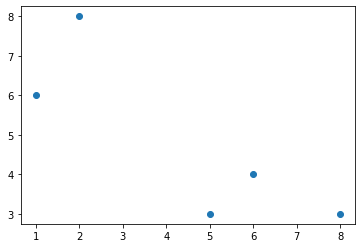

In [14]:
X = np.array([(8, 3), (5, 3), (6, 4), (1, 6), (2, 8)])
scaled_X = normalize(X)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Let's plot the dendrogram with `scipy.cluster.hierarchy` library

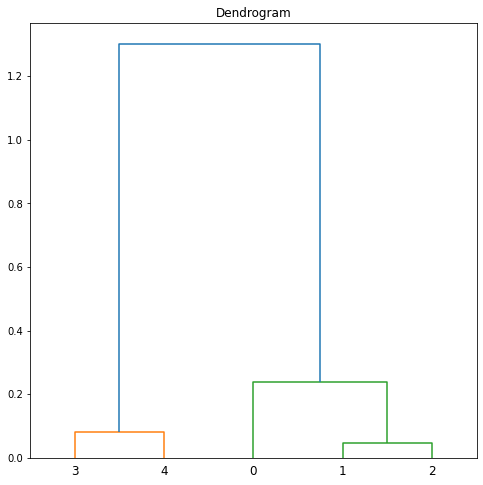

In [17]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 8))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_X, method="ward"))

HAC is implemented in `sklearn.cluster` module as `AgglomerativeClustering` class